In [2]:
import pandas as pd
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Dataset/umist_faces.csv')

In [4]:
# # df.duplicated()
# # Custom funciton to check for duplicates
# counter = 0
# # If the vaues are duplicated then the label is also gonna be same
# for i in range(len(df)):
#     for j in range(i+1, len(df)):
#         # Check for the same image if the labels are same
#         if(df.iloc[i, 0] == df.iloc[j, 0]):
#             # Check if the rows are same
#             if(df.iloc[i, 1:].equals(df.iloc[j, 1:])):
#                 print("Duplicate found")
#                 print(df.iloc[i, 0])
#                 print(df.iloc[j, 0])
#                 print("Row 1: ", df.iloc[i, 1:])
#                 print("Row 2: ", df.iloc[j, 1:])
#                 counter += 1
#                 print("\n\n")
                
# print("Total duplicates found: ", counter)
        

In [5]:
# Dropping the duplicates
df = df.drop_duplicates()
df.shape

(565, 10305)

In [6]:
X = df.drop('label', axis=1).values
y = df['label']

In [7]:
# Check if there are any duplicates
df.duplicated().sum()

0

In [8]:
# Reshape images (assuming 112x92 image size)
image_size = (112, 92)
X = X.reshape(-1, *image_size)

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [10]:
from sklearn.model_selection import train_test_split
# Split data into training, testing, and validation sets using stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

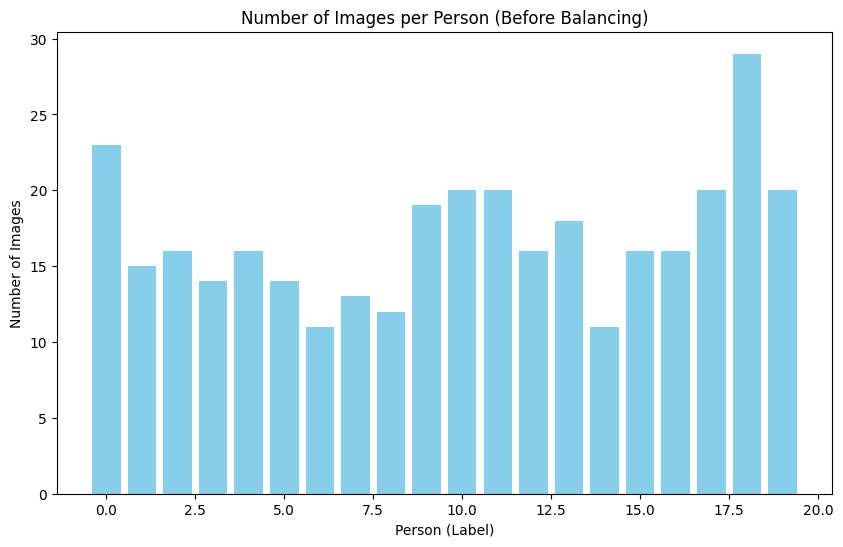

Balanced dataset shape: (960, 112, 92, 1), (960,)


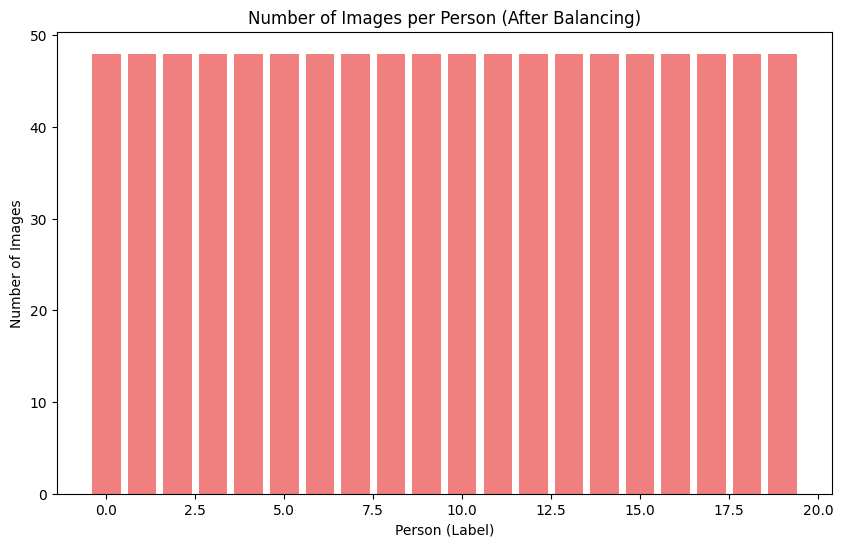

In [11]:
# Balance the training dataset using ImageDataGenerator
TARGET_IMAGES_PER_PERSON = 48

# Split the dataset by label
unique_labels = np.unique(y_train)
label_to_images = {label: X_train[y_train == label] for label in unique_labels}

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Before balancing: plot the number of images per person
initial_counts = [np.sum(y_train == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, initial_counts, color='skyblue')
plt.title('Number of Images per Person (Before Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

balanced_X = []
balanced_y = []

for label, images in label_to_images.items():
    num_images = images.shape[0]
    if num_images < TARGET_IMAGES_PER_PERSON:
        # Add channel dimension to images (assuming grayscale images)
        images = np.expand_dims(images, axis=-1)  # Shape becomes (num_images, height, width, 1)
        
        # Generate augmented images
        augmented_images = []
        for x in datagen.flow(images, batch_size=1, seed=42):
            augmented_images.append(x[0])  # x is a batch, take the first image
            if len(augmented_images) + num_images >= TARGET_IMAGES_PER_PERSON:
                break
        combined_images = np.concatenate([images, np.array(augmented_images)])
    else:
        # Randomly select TARGET_IMAGES_PER_PERSON images
        combined_images = images[np.random.choice(num_images, TARGET_IMAGES_PER_PERSON, replace=False)]

    balanced_X.extend(combined_images)
    balanced_y.extend([label] * TARGET_IMAGES_PER_PERSON)

# Convert balanced dataset to numpy arrays
balanced_X = np.array(balanced_X)
balanced_y = np.array(balanced_y)

print(f"Balanced dataset shape: {balanced_X.shape}, {balanced_y.shape}")

# After balancing: plot the number of images per person
balanced_counts = [np.sum(balanced_y == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, balanced_counts, color='lightcoral')
plt.title('Number of Images per Person (After Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

// Preprocessing Steps

In [12]:
X_train = balanced_X.reshape(balanced_X.shape[0], -1)
y_train = balanced_y

In [13]:
# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [14]:
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [15]:
# Pca for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [16]:
pca.explained_variance_ratio_.sum()

0.9900388470349265

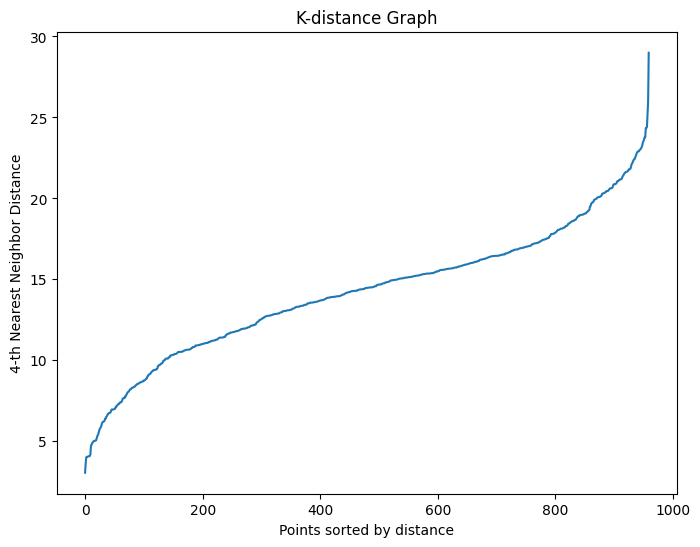

Best eps (based on silhouette score): 2.5000000000000004
Best Silhouette Score: -0.09362305941360281
Optimal epsilon value: 22


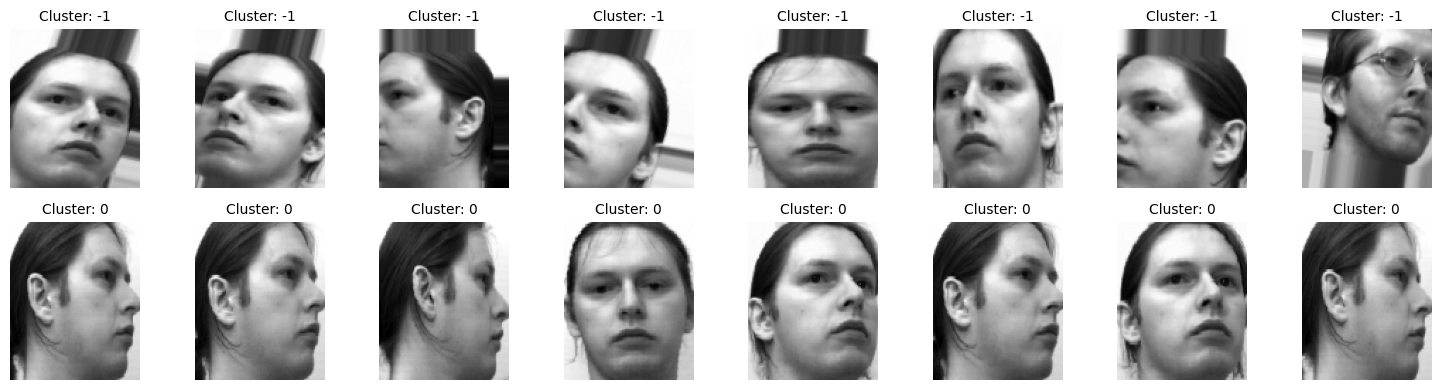

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# 1. K-distance Graph (Elbow Method)
def plot_k_distance_graph(X, k=4):
    # Compute the k-nearest neighbors for each point
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    
    # Sort the distances to the k-th nearest neighbors
    distances = np.sort(distances[:, k-1], axis=0)
    
    # Plot the K-distance graph
    plt.figure(figsize=(8, 6))
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title(f'K-distance Graph')
    plt.show()

# 2. Silhouette Score Maximization
def find_best_eps_using_silhouette(X, min_samples=3, eps_range=np.arange(0.1, 10, 0.1)):
    best_eps = None
    best_score = -1

    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        y_dbscan = dbscan.fit_predict(X)
        
        # Ignore cases where all points are noise or single cluster
        if len(set(y_dbscan)) <= 1:
            continue
        
        # Compute silhouette score
        score = silhouette_score(X, y_dbscan)
        
        if score > best_score:
            best_eps = eps
            best_score = score

    return best_eps, best_score

# 3. Main code for combining methods
def main(X_train_pca, X_train_original):
    # Plot K-distance graph
    plot_k_distance_graph(X_train_pca, k=4)

    # Find the best eps using silhouette score
    best_eps, best_score = find_best_eps_using_silhouette(X_train_pca)

    print(f"Best eps (based on silhouette score): {best_eps}")
    print(f"Best Silhouette Score: {best_score}")
    best_eps = 22
    # Train DBSCAN with the best epsilon value
    dbscan = DBSCAN(eps=22, min_samples=6)
    y_dbscan_train = dbscan.fit_predict(X_train_pca)
    
    print(f"Optimal epsilon value: {best_eps}")

    # Visualizing the clusters
    y_dbscan_unique = np.unique(y_dbscan_train)
    plt.figure(figsize=(15, len(y_dbscan_unique) * 2))  # Adjust the figure size as needed

    for i, cluster in enumerate(y_dbscan_unique):
        indices = np.where(y_dbscan_train == cluster)[0]
        for j, index in enumerate(indices):
            if j >= 8:  # Limit to 8 images per cluster for better visualization
                break
            plt.subplot(len(y_dbscan_unique), 8, i * 8 + j + 1)
            plt.imshow(np.reshape(X_train_original[index], (112, 92)), cmap=plt.cm.gray)
            plt.title('Cluster: ' + str(cluster), fontsize=10)
            plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Assuming X_train_pca is your PCA-reduced dataset and X_train_original is the original dataset
main(X_train_pca, X_train)

Best eps: 2.5000000000000004, Best Silhouette Score: -0.09362305941360281
Optimal epsilon value: 9.9


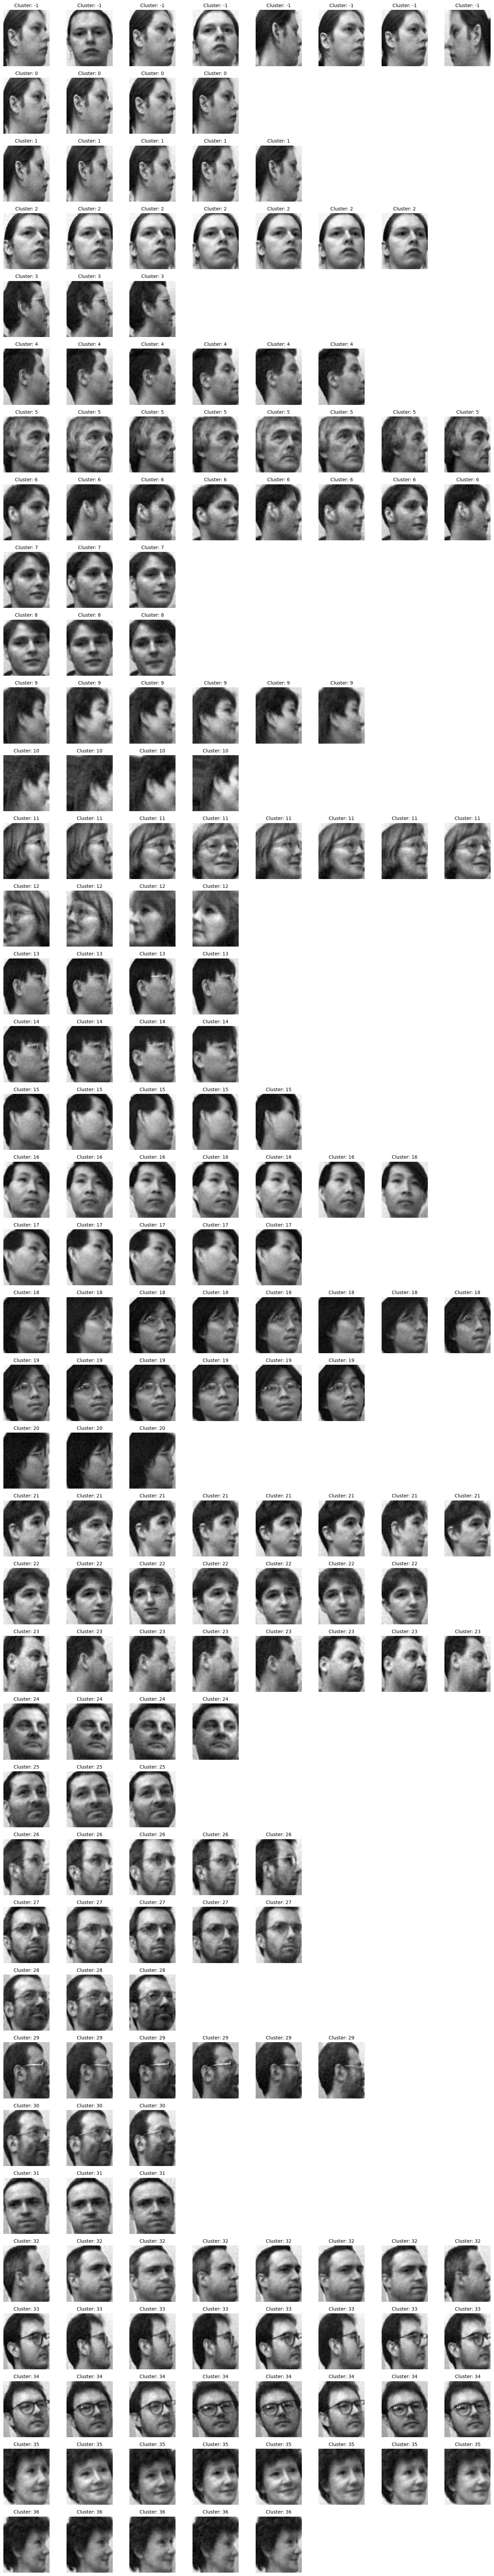

In [ ]:
# # Implementing the DBSCAN clustering algorithm
# from sklearn.cluster import DBSCAN

# from sklearn.metrics import silhouette_score
# import numpy as np

# best_eps = None
# best_score = -1  # For silhouette, higher is better
# min_samples = 3

# for eps in np.arange(0.1, 10, 0.1):
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     y_dbscan = dbscan.fit_predict(X_train_pca)
    
#     # Ignore cases where all points are noise or single cluster
#     if len(set(y_dbscan)) <= 1:
#         continue
    
#     # Compute the silhouette score (only for clusters with >1 label)
#     score = silhouette_score(X_train_pca, y_dbscan)
#     if score > best_score:
#         best_eps = eps
#         best_score = score

# print(f"Best eps: {best_eps}, Best Silhouette Score: {best_score}")

# # Train DBSCAN with the best epsilon value
# dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
# y_dbscan_train = dbscan.fit_predict(X_train_pca)


# print(f"Optimal epsilon value: {eps}")

# y_dbscan_unique = np.unique(y_dbscan)
# plt.figure(figsize=(15, len(y_dbscan_unique) * 2))  # Adjust the figure size as needed

# X_train_reconstructed = pca.inverse_transform(X_train_pca)
# X_val_reconstructed = pca.inverse_transform(X_val_pca)
# X_test_reconstructed = pca.inverse_transform(X_test_pca)
# for i, cluster in enumerate(y_dbscan_unique):
#     indices = np.where(y_dbscan == cluster)[0]
#     for j, index in enumerate(indices):
#         if j >= 8:  # Limit to 8 images per cluster for better visualization
#             break
#         plt.subplot(len(y_dbscan_unique), 8, i * 8 + j + 1)
#         plt.imshow(np.reshape(X_train_reconstructed[index], (112, 92)), cmap=plt.cm.gray)
#         plt.title('Cluster: ' + str(cluster), fontsize=10)
#         plt.axis('off')
        
# plt.tight_layout()
# plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


num_clusters = len(np.unique(y_dbscan_train))  
clusters_one_hot = to_categorical(y_dbscan_train, num_clusters)
X_train_augmented = np.hstack((X_train_pca, clusters_one_hot))
X_val_clusters = to_categorical(dbscan.fit_predict(X_val_pca), num_clusters)
X_val_augmented = np.hstack((X_val_pca, X_val_clusters))
X_test_clusters = to_categorical(dbscan.fit_predict(X_test_pca), num_clusters)
X_test_augmented = np.hstack((X_test_pca, X_test_clusters))


Augmented Shapes: (960, 420) (113, 420) (113, 420)


In [ ]:
# One-hot encode labels for classification
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [ ]:
# Check the shape of X_train_augmented
input_shape = X_train_augmented.shape[1]

# Build the neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(y_train_one_hot.shape[1], activation='softmax')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_augmented, y_train_one_hot,
    validation_data=(X_val_augmented, y_val_one_hot),
    epochs=50,
    batch_size=32
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0739 - loss: 8.1873 - val_accuracy: 0.3451 - val_loss: 6.4430
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1570 - loss: 6.5740 - val_accuracy: 0.5398 - val_loss: 5.3484
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2159 - loss: 5.6251 - val_accuracy: 0.7522 - val_loss: 4.4151
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3041 - loss: 4.8688 - val_accuracy: 0.8673 - val_loss: 3.6633
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3812 - loss: 4.2201 - val_accuracy: 0.8584 - val_loss: 3.0855
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4463 - loss: 3.7622 - val_accuracy: 0.9027 - val_loss: 2.6454
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5188 - loss: 3.4133 - val_accuracy: 0.8850 - val_loss: 2.3109
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5492 - loss: 3.0957 - val_accuracy: 0.9027 - val_loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.6282 
Test Loss: 0.6194515824317932
Test Accuracy: 0.982300877571106


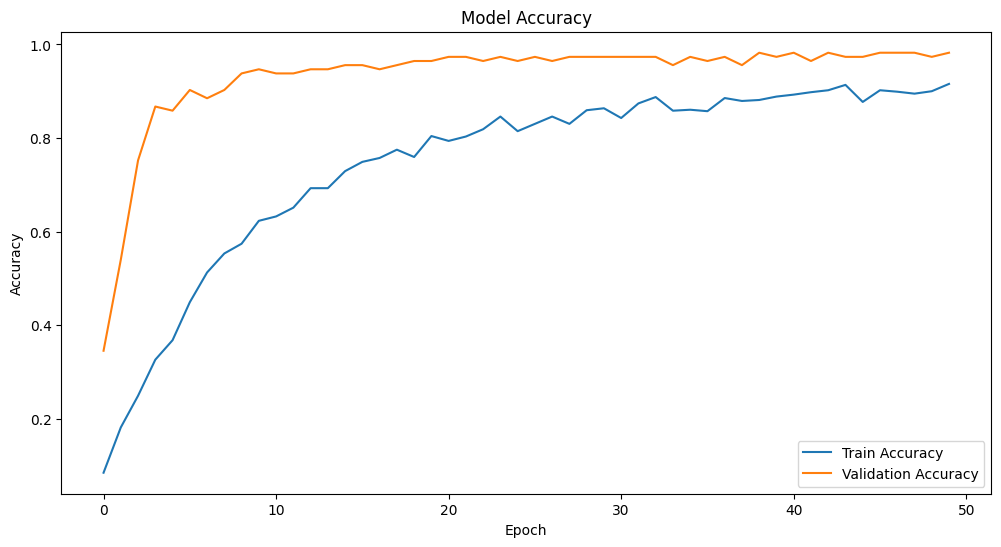

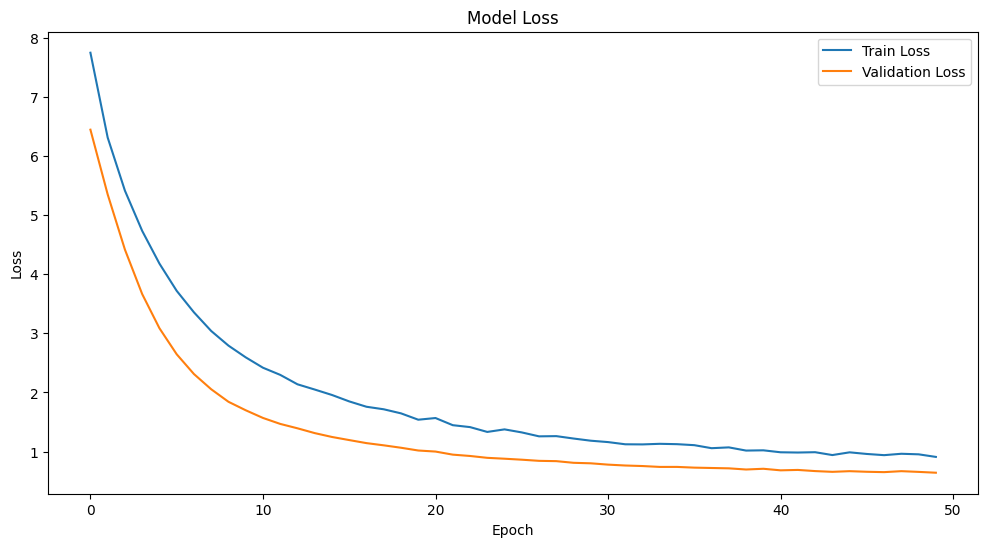

In [ ]:
# Evaluate the model
results = model.evaluate(X_test_augmented, y_test_one_hot)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


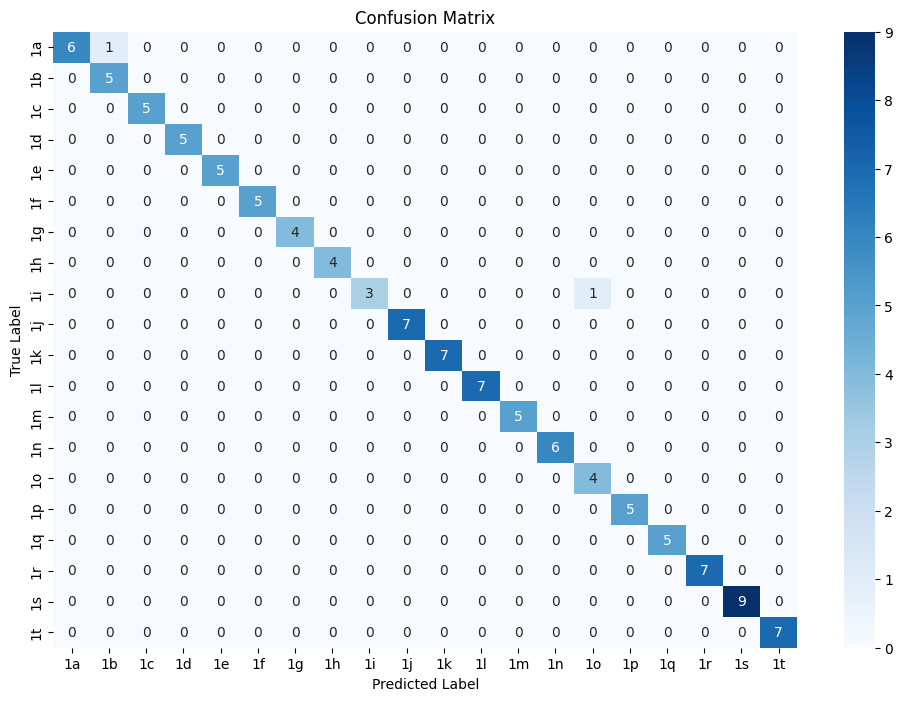

In [ ]:
# Predictions
y_pred = model.predict(X_test_augmented)
y_pred = np.argmax(y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


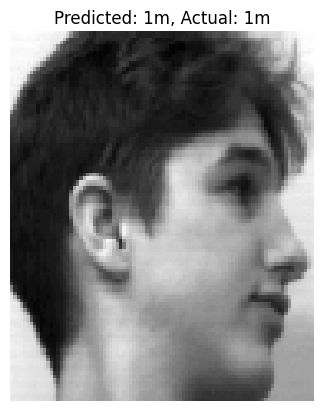

In [ ]:
random_index = np.random.randint(1, X_test.shape[0])
random_image = X_test[random_index]

# Reshape the image to (1, 112, 92) to match the model input dimensions
random_image = random_image.reshape(1, -1)


random_image_pca = pca.transform(random_image)

random_image_cluster = dbscan.fit_predict(random_image_pca)
random_image_cluster_one_hot = to_categorical(random_image_cluster, num_clusters)
random_image_augmented = np.hstack((random_image_pca, random_image_cluster_one_hot))

# Make a prediction
prediction = model.predict(random_image_augmented)
predicted_label = np.argmax(prediction)
actual_label = y_test[random_index]

# Display the image and prediction and actual label
plt.imshow(np.reshape(random_image, (112, 92)), cmap='gray')
plt.title(f'Predicted: {le.inverse_transform([predicted_label])[0]}, Actual: {le.inverse_transform([actual_label])[0]}')
plt.axis('off')
plt.show()
